## Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
# from napari_convpaint.conv_paint_utils import *
# from napari_convpaint.conv_paint_model import *
# from napari_convpaint.conv_paint_param import Param
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import napari
from skimage import morphology
import seaborn as sns
import pandas as pd
from aicsimageio import AICSImage

from CellAnalyzer import CellAnalyzer

06-Jun-25 06:13:49 - bfio.backends - WARNING  - Java backend is not available. This could be due to a missing dependency (jpype).


## Data loading and inspection

Create an object with the path to the data.

In [44]:
in_path = "../imaging_data/21122022_images_jinglecells_SO_AK/MERS"
ca = CellAnalyzer(in_path)

>>> GPU activated? NO


Display the data table.

In [ ]:
df, imgs = ca.read_data()
display(df)

,condition,donor,time,date,sample,replicate,sample_id,mode1,mode2,filename,filepath,projection_types
0,37mock,BEC5,48h,2021-12-22,00,1,BEC5_1,R3D,D3D,37mock_BEC5_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...,"[max, max, max, max]"
1,37mock,BEC5,48h,2021-12-22,01,2,BEC5_2,R3D,D3D,37mock_BEC5_48h_21.12.22.01_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...,"[max, max, max, max]"
2,37mock,BEC5,48h,2021-12-22,03,3,BEC5_3,R3D,D3D,37mock_BEC5_48h_21.12.22.03_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...,"[max, max, max, max]"
3,37mock,BEC6,48h,2021-12-22,00,1,BEC6_1,R3D,D3D,37mock_BEC6_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...,"[max, max, max, max]"
4,MERS,BEC5,48h,2021-12-22,00,1,BEC5_1,R3D,D3D,MERS_BEC5_48h_21.12.22_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...,"[max, max, max, max]"
5,MERS,BEC5,48h,2021-12-23,00,2,BEC5_2,R3D,D3D,MERS_BEC5_48h_21.12.23_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...,"[max, max, max, max]"
6,MERS,BEC6,48h,2021-12-22,01,1,BEC6_1,R3D,D3D,MERS_BEC6_48h_21.12.22.01_R3D_D3D.dv,C:\Users\roman\Documents\Vetsuisse\imaging_dat...,"[max, max, max, max]"


Check dimensions.

In [117]:
imgs[0].shape

(4, 68, 960, 960)

Create projections.

In [118]:
projections = ca.create_projections(types=["max", "max", "max", "max"]) # Projection options: max, min, mean, median

In [119]:
print(ca.projections[0].shape)
print(ca.projections_types)

(4, 960, 960)
['max', 'max', 'max', 'max']


## Segmentation

In [120]:
masks, flows, styles, imgs_dn, outlines = ca.segment(channels=[3,1]) # Channels for: Cytoplasm, Nucleus

In [ ]:
# ca.save(overwrite=True)

Instead of doing the steps above over and over again, we can load a saved state

In [ ]:
# ca = CellAnalyzer.load(in_path + "/CellAnalyzer/CellAnalyzer.pkl")

>>> GPU activated? NO
>>> GPU activated? NO


Check to make sure the data was loaded correctly (hiding the irrelevant columns); after segmentation, the table now includes information about the IDs of the cells in each sample

In [59]:
ca.df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])

,condition,donor,replicate,sample_id,num_cells,cell_id_min,cell_id_max
0,37mock,BEC5,1,BEC5_1,343,1,343
1,37mock,BEC5,2,BEC5_2,306,344,649
2,37mock,BEC5,3,BEC5_3,331,650,980
3,37mock,BEC6,1,BEC6_1,359,981,1339
4,MERS,BEC5,1,BEC5_1,201,1340,1540
5,MERS,BEC5,2,BEC5_2,259,1541,1799
6,MERS,BEC6,1,BEC6_1,334,1800,2133


And we now also have a cells table, which contains the information about the sample plus cell-specific information

In [60]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])
cells_df.iloc[1200:1205]

,condition,donor,replicate,sample_id,cell_id,cilia_mean,inf_mean,cilia_mean_log10,inf_mean_log10
1200,37mock,BEC6,1,BEC6_1,1201,4685.717466,663.558219,3.670776,2.821879
1201,37mock,BEC6,1,BEC6_1,1202,5267.037348,680.481707,3.721566,2.832816
1202,37mock,BEC6,1,BEC6_1,1203,4266.040141,667.770423,3.630025,2.824627
1203,37mock,BEC6,1,BEC6_1,1204,4862.489869,680.087798,3.686859,2.832565
1204,37mock,BEC6,1,BEC6_1,1205,4480.508189,664.789017,3.651327,2.822684


Save segmentation results, just for viusalization purposes

In [31]:
ca.save_segmentation_imgs(background_channels=[4,2])

Outlines saved.
Masks saved.


## Calculate Cell Means

In [ ]:
ca.get_cell_signals({"cilia": 4, "inf": 2}, mode="mean")

We can get the masks with the signal means for each cell

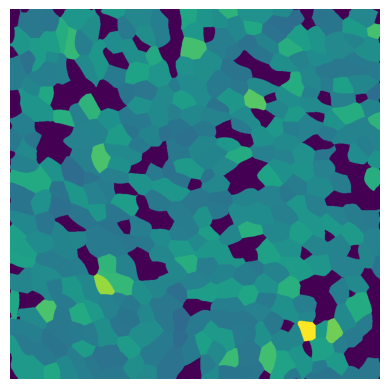

In [89]:
ex_mean_mask = ca.signals_masks["cilia"][3]
plt.imshow(ex_mean_mask)
plt.axis("off")
plt.show()

Save or load the data

In [ ]:
# ca.save(overwrite=True)

In [ ]:
# ca = CellAnalyzer.load(in_path + "/CellAnalyzer/CellAnalyzer.pkl")

>>> GPU activated? NO
>>> GPU activated? NO


## Define threshold and bin cells

In [90]:
cells_df = ca.cells_df.drop(columns=["time", "date", "sample", "mode1", "mode2", "filename", "filepath", "projection_types"])

In [91]:
cells_df[100:105]

,condition,donor,replicate,sample_id,cell_id,cilia_mean,inf_mean,cilia_mean_log10,inf_mean_log10,cilia_median,cilia_median_log10,inf_median,inf_median_log10
100,37mock,BEC5,1,BEC5_1,101,8412.242499,787.143876,3.924912,2.896054,8246.5,3.916270,781.0,2.892651
101,37mock,BEC5,1,BEC5_1,102,6998.027225,738.749389,3.844976,2.868497,6460.0,3.810233,729.0,2.862728
102,37mock,BEC5,1,BEC5_1,103,8252.469059,761.763201,3.916584,2.881820,8093.5,3.908136,755.0,2.877947
103,37mock,BEC5,1,BEC5_1,104,7182.439170,734.362422,3.856272,2.865910,6728.0,3.827886,726.0,2.860937
104,37mock,BEC5,1,BEC5_1,105,5421.504120,670.012118,3.734120,2.826083,4605.0,3.663230,657.0,2.817565


In [ ]:
mock_inf_log10 = cells_df[cells_df["condition"].str.contains("mock")]["inf_mean_log10"]
inf_log10_thresh = mock_inf_log10.mean() + 3 * mock_inf_log10.std()
print(f"Inf log10 threshold: {inf_log10_thresh}")

Inf log10 threshold: 3.8814102152725205


In [95]:
margin = 1 * mock_inf_log10.std()
cells_df["inf_bin"] = "non-infected"
cells_df.loc[cells_df["inf_mean_log10"] > (inf_log10_thresh - margin), "inf_bin"] = "low"
cells_df.loc[cells_df["inf_mean_log10"] > inf_log10_thresh, "inf_bin"] = "high"

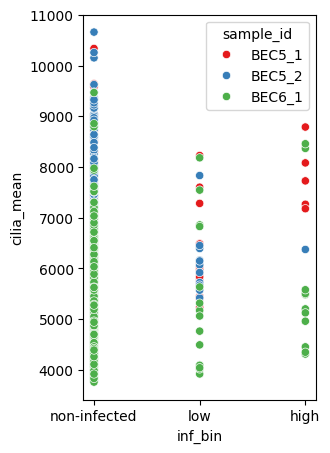

In [99]:
fig, ax = plt.subplots(figsize=(3, 5), dpi=100)
sns.scatterplot(data=cells_df[cells_df["condition"].str.contains("MERS")], x='inf_bin', y='cilia_mean', palette="Set1", hue="sample_id", ax=ax)
plt.show()